In [1]:
import simpy
import random
import numpy
import matplotlib.pyplot as plt
from scipy.interpolate import spline

In [166]:
'''
Task Stealing Simulation
'''

def process_packet(env, short):
    #print('Packet {0} Process Server {1} type {2}'.format(self.name, self.env.now, self.short))
    if short:
        #yield env.timeout(numpy.random.poisson(20))
        yield env.timeout(random.expovariate(1.0 / 20))
    else:
        #yield env.timeout(numpy.random.poisson(40))
        yield env.timeout(random.expovariate(1.0 / 40))
        
        


def Packet(env, queue, data, data_log, short):
    queue_to_work_on = queue

    #print('Packet Start Server {0} type {1}'.format(env.now, short))
    arrival_time = env.now
    with queue_to_work_on.request() as req:
        yield req
        yield env.process(process_packet(env, short))
        #print('Packet Leaving Server {0} type {1}'.format(env.now, 1))
        leave_time = env.now
        #print(self.short ,leave_time - arrival_time)
        if short:
            data_log[0].append(leave_time - arrival_time)
            data[0][0] = data[0][0] + leave_time - arrival_time
            data[0][1] = data[0][1] + 1
        else:
            data_log[1].append(leave_time - arrival_time)
            data[1][0] = data[1][0] + leave_time - arrival_time
            data[1][1] = data[1][1] + 1
            
def send_long_packet(env, total_packet_number, long_queue, data, data_log, inter_arrival):
    counter = 0
    for i in range(total_packet_number):
        inter_arrival_time = random.expovariate(1.0 / inter_arrival)
        short = random.choice([0])
        yield env.timeout(inter_arrival_time)
        env.process(Packet(env, long_queue, data, data_log, short))
    

def send_packet_steal(env, total_packet_number, short_queue, long_queue, data, data_log, inter_arrival):
    counter = 0
    for i in range(total_packet_number):
        inter_arrival_time = random.expovariate(1.0 / inter_arrival)
        short = random.choice([1])
        yield env.timeout(inter_arrival_time)
        if not long_queue.count:
            counter += 1
            #print(counter)
            env.process(Packet(env, long_queue, data, data_log, short))
            continue
        env.process(Packet(env, short_queue, data, data_log, short))
    

def send_packet_without_steal(env, total_packet_number, short_queue, data, data_log, inter_arrival):
    counter = 0
    for i in range(total_packet_number):
        #inter_arrival_time = numpy.random.poisson(40)
        inter_arrival_time = random.expovariate(1.0 / inter_arrival)
        short = random.choice([1])
        yield env.timeout(inter_arrival_time)
        env.process(Packet(env, short_queue, data, data_log, short))

storage_steal = []
storage_without_steal = []
long_job_inter_arrival = 100

            
for i in range(70,13, -1):#[70, 60, 50, 40, 30, 20, 14]:
    env = simpy.Environment()
    data = [[0,0],[0,0]] #[average_mean_response_time_short, average_mean_response_time_long]
    data_log = [[], []]
    short_queue = simpy.Resource(env, capacity=1)
    long_queue = simpy.Resource(env, capacity=1)
    env.process(send_packet_steal(env, 2000, short_queue, long_queue, data, data_log, i))
    env.process(send_long_packet(env, 2000, long_queue, data, data_log, long_job_inter_arrival))
    env.run(until=10000000)
    storage_steal.append([numpy.percentile(data_log[0], 99.9), numpy.percentile(data_log[1], 99.9), i])
    print(numpy.percentile(data_log[0], 99.9), numpy.percentile(data_log[1], 99.9))

for i in range(70,13, -1):#[70, 60, 50, 40, 30, 20, 14]:
    env = simpy.Environment()
    data = [[0,0],[0,0]] #[average_mean_response_time_short, average_mean_response_time_long]
    data_log = [[], []]
    short_queue = simpy.Resource(env, capacity=1)
    long_queue = simpy.Resource(env, capacity=1)
    env.process(send_packet_without_steal(env, 2000, short_queue, data, data_log, i))
    env.process(send_long_packet(env, 2000, long_queue, data, data_log, long_job_inter_arrival))
    env.run(until=10000000)
    storage_without_steal.append([numpy.percentile(data_log[0], 99.9), numpy.percentile(data_log[1], 99.9), i])
    print(numpy.percentile(data_log[0], 99.9), numpy.percentile(data_log[1], 99.9))

#print(data_log)
#print(data)
#print(numpy.percentile(data_log[0], 99.9), numpy.percentile(data_log[1], 99.9))

130.44995219857728 473.3023574755316
156.64254164347503 475.2324579465397
146.28540852008274 445.9375428351654
167.3623712785043 456.5190757029175
236.59062076438605 656.1284178872027
148.6432375985911 332.6193263537215
192.99802063097945 328.23015126483745
161.00626904914765 467.81831469201575
131.20138189606857 507.51085227155664
148.32420077714406 383.7311977882466
166.59566596855012 699.7811956278726
207.13516145290646 306.0352460774682
193.31895053772368 406.73819807436155
140.6826419465032 430.3136012108868
187.0929191889712 411.89848581710993
188.68529317401044 358.12220328728944
159.07384410493614 373.194130993555
155.56367764841676 400.1825378497772
194.2399840993691 358.7101639355911
141.96409546139466 441.90967978835454
169.31308248730696 430.65874501158873
176.16810046945275 394.00356854930413
231.6997979954824 444.91319943573956
177.48532768118494 405.1916459376379
159.26322840785707 390.4200741182697
149.18001196144402 439.8874968700832
232.25495232410444 423.857849176608

157 157


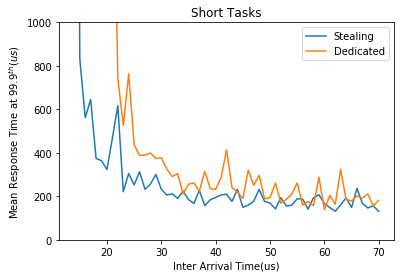

In [170]:
'''
Task Stealing
Drawing Short Tasks
Just run
'''

fig, ax = plt.subplots()

# x = numpy.arange(len(data_log[0]))
# y = data_log[0]
storage_steal = numpy.array(storage_steal)
storage_without_steal = numpy.array(storage_without_steal)
print(len(x), len(y))
ax.plot(storage_steal[:,2], storage_steal[:,0], label='Stealing')
ax.plot(storage_without_steal[:,2], storage_without_steal[:,0], label='Dedicated')
ax.set_xlabel('Inter Arrival Time(us)')
ax.set_ylabel('Mean Response Time at $99.9^{th}(us)$')
ax.set_ylim((0,1000))
ax.legend()
ax.set_title(r'Short Tasks')
plt.savefig('plots/dedicated_stealing_short.png', bbox_inches='tight', dpi=300)
plt.show()

157 157


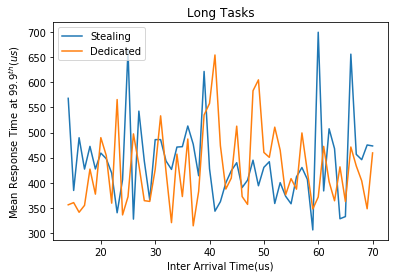

In [169]:
'''
Task Stealing
Drawing Long Tasks
Just Run
'''

fig, ax = plt.subplots()

# x = numpy.arange(len(data_log[0]))
# y = data_log[0]
storage_steal = numpy.array(storage_steal)
storage_without_steal = numpy.array(storage_without_steal)
print(len(x), len(y))
ax.plot(storage_steal[:,2], storage_steal[:,1], label='Stealing')
ax.plot(storage_without_steal[:,2], storage_without_steal[:,1], label='Dedicated')
ax.set_xlabel('Inter Arrival Time(us)')
ax.set_ylabel('Mean Response Time at $99.9^{th}(us)$')
ax.legend()
ax.set_title(r'Long Tasks')
plt.savefig('plots/dedicated_stealing_long.png', bbox_inches='tight', dpi=300)
plt.show()

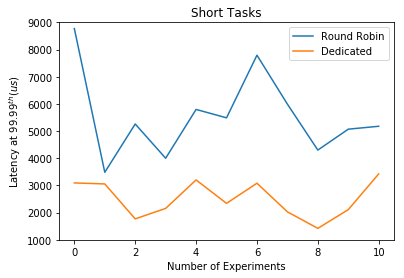

In [15]:
fig, ax = plt.subplots()

x = numpy.arange(11)
# y = data_log[0]

default99 = [931.6, 900.2, 932.3, 928.2, 917.0, 911.8, 947.1, 900.8, 923.0, 933.6, 941.9]
default999 = [2308.7, 1528.7, 1623.5, 1529.9, 1576.1, 1461.5, 1705.5, 1472.8, 1493.8, 1612.4, 1856.2]
default9999 = [8771.5, 3484.1, 5260.9, 4000.6, 5796.7, 5487.2, 7791.7, 5991.8, 4301.4, 5070.1, 5177.0]

improved99 = [887.5, 867.1, 861.9, 866.4, 853.2, 867.7, 862.5, 864.8, 861.3, 861.6, 868.6]
improved999 = [1429.2, 1336.9, 1116.2, 1186.5, 1303.1, 1182.9, 1420.1, 1174.6, 1051.0, 1181.4, 1385.7]
improved9999 = [3092.7, 3055.1, 1770.2, 2154.7, 3202.5, 2340.8, 3081.4, 2028.9, 1420.9, 2110.0, 3424.2]

# storage_steal = numpy.array(storage_steal)
# storage_without_steal = numpy.array(storage_without_steal)
ax.plot(x, default9999, label='Round Robin')
ax.plot(x, improved9999, label='Dedicated')

ax.set_xlabel('Number of Experiments')
ax.set_ylabel('Latency at $99.99^{th}(us)$')
ax.set_ylim((1000,9000))
ax.legend()
ax.set_title(r'Short Tasks')
plt.savefig('plots/dedicated_nic_9999.png', bbox_inches='tight', dpi=300)
plt.show()

In [39]:
#default99 = [931.6, 900.2, 932.3, 928.2, 917.0, 911.8, 947.1, 900.8, 923.0, 933.6, 941.9]
#default999 = [2308.7, 1528.7, 1623.5, 1529.9, 1576.1, 1461.5, 1705.5, 1472.8, 1493.8, 1612.4, 1856.2]
#default9999 = [8771.5, 3484.1, 5260.9, 4000.6, 5796.7, 5487.2, 7791.7, 5991.8, 4301.4, 5070.1, 5177.0]

#improved99 = [887.5, 867.1, 861.9, 866.4, 853.2, 867.7, 862.5, 864.8, 861.3, 861.6, 868.6]
#improved999 = [1429.2, 1336.9, 1116.2, 1186.5, 1303.1, 1182.9, 1420.1, 1174.6, 1051.0, 1181.4, 1385.7]
#improved9999 = [3092.7, 3055.1, 1770.2, 2154.7, 3202.5, 2340.8, 3081.4, 2028.9, 1420.9, 2110.0, 3424.2]

offload99 = numpy.loadtxt("../results/offloading_2.txt", skiprows=20, delimiter=' ', usecols=0)
offload999 = numpy.loadtxt("../results/offloading_2.txt", skiprows=20, delimiter=' ', usecols=1)
offload9999 = numpy.loadtxt("../results/offloading_2.txt", skiprows=20, delimiter=' ', usecols=2)

dedicated99 = numpy.loadtxt("../results/dedicated_1.txt", skiprows=20, delimiter=' ', usecols=0)
dedicated999 = numpy.loadtxt("../results/dedicated_1.txt", skiprows=20, delimiter=' ', usecols=1)
dedicated9999 = numpy.loadtxt("../results/dedicated_1.txt", skiprows=20, delimiter=' ', usecols=2)

round99 = numpy.loadtxt("../results/round.txt", skiprows=20, delimiter=' ', usecols=0)
round999 = numpy.loadtxt("../results/round.txt", skiprows=20, delimiter=' ', usecols=1)
round9999 = numpy.loadtxt("../results/round.txt", skiprows=20, delimiter=' ', usecols=2)


print(numpy.var(round99))
print(numpy.var(round999))
print(numpy.var(round9999))
print("$$$$$")

print(numpy.var(dedicated99))
print(numpy.var(dedicated999))
print(numpy.var(dedicated9999))
print("$$$$")

print(numpy.var(offload99))
print(numpy.var(offload999))
print(numpy.var(offload9999))

180.816441207076
4581.496482830384
13468821.490176905
$$$$$
79.48482830385028
3341.8564828303847
323024.80580645165
$$$$
111.46938605619148
1319.3797918834555
154247.12385015612


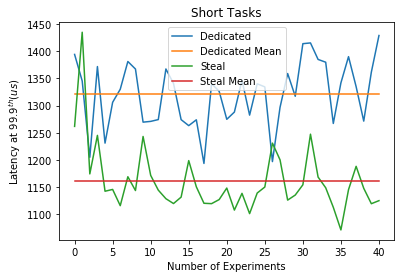

In [32]:
fig, ax = plt.subplots()

line1 = dedicated999_1
line2 = offload999_1
#line3 = round99

x1 = numpy.arange(len(line1))
x2 = numpy.arange(len(line2))
#x3 = numpy.arange(len(line3))


# x1new = numpy.linspace(x1.min(),x1.max(),20)
# x2new = numpy.linspace(x2.min(),x2.max(),20)

# line1_smooth = spline(x1, line1, x1new)
# line2_smooth = spline(x2, line2, x2new)

# storage_steal = numpy.array(storage_steal)
# storage_without_steal = numpy.array(storage_without_steal)

mean_line1 = [numpy.mean(line1)]*len(x1)
mean_line2 = [numpy.mean(line2)]*len(x2)
#mean_line3 = [numpy.mean(line3)]*len(x3)



#ax.plot(x1, default999, label='Round Robin')
ax.plot(x1, line1, label='Dedicated')
# ax.plot(x1new, line1_smooth, label='Dedicated Smooth')
ax.plot(x1, mean_line1, label='Dedicated Mean')



ax.plot(x2, line2, label='Steal')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
ax.plot(x2, mean_line2, label='Steal Mean')


#ax.plot(x3, line3, label='Round Robin')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
#ax.plot(x3, mean_line3, label='Round Robin Mean')


# ax.axvline(x2.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_xlabel('Number of Experiments')
ax.set_ylabel('Latency at $99.9^{th}(us)$')
# ax.set_ylim((820,880))
ax.legend()
ax.set_title(r'Short Tasks')
plt.savefig('plots/off_ded_nic_999.png', bbox_inches='tight', dpi=300)
plt.show()

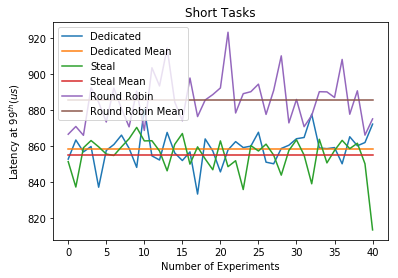

In [26]:
fig, ax = plt.subplots()

line1 = dedicated99_1
line2 = offload99_1
line3 = round99

x1 = numpy.arange(len(line1))
x2 = numpy.arange(len(line2))
x3 = numpy.arange(len(line3))


# x1new = numpy.linspace(x1.min(),x1.max(),20)
# x2new = numpy.linspace(x2.min(),x2.max(),20)

# line1_smooth = spline(x1, line1, x1new)
# line2_smooth = spline(x2, line2, x2new)

# storage_steal = numpy.array(storage_steal)
# storage_without_steal = numpy.array(storage_without_steal)

mean_line1 = [numpy.mean(line1)]*len(x1)
mean_line2 = [numpy.mean(line2)]*len(x2)
mean_line3 = [numpy.mean(line3)]*len(x3)



#ax.plot(x1, default999, label='Round Robin')
ax.plot(x1, line1, label='Dedicated')
# ax.plot(x1new, line1_smooth, label='Dedicated Smooth')
ax.plot(x1, mean_line1, label='Dedicated Mean')



ax.plot(x2, line2, label='Steal')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
ax.plot(x2, mean_line2, label='Steal Mean')


ax.plot(x3, line3, label='Round Robin')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
ax.plot(x3, mean_line3, label='Round Robin Mean')


# ax.axvline(x2.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_xlabel('Number of Experiments')
ax.set_ylabel('Latency at $99^{th}(us)$')
# ax.set_ylim((800,1500))
ax.legend()
ax.set_title(r'Short Tasks')
plt.savefig('plots/off_nic_99.png', bbox_inches='tight', dpi=300)
plt.show()

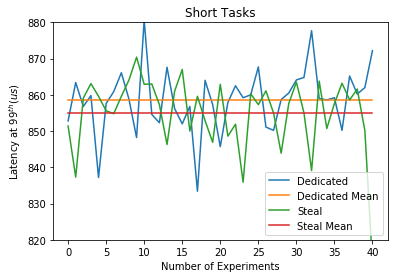

In [30]:
fig, ax = plt.subplots()

line1 = dedicated99_1
line2 = offload99_1
#line3 = round99

x1 = numpy.arange(len(line1))
x2 = numpy.arange(len(line2))
#x3 = numpy.arange(len(line3))


# x1new = numpy.linspace(x1.min(),x1.max(),20)
# x2new = numpy.linspace(x2.min(),x2.max(),20)

# line1_smooth = spline(x1, line1, x1new)
# line2_smooth = spline(x2, line2, x2new)

# storage_steal = numpy.array(storage_steal)
# storage_without_steal = numpy.array(storage_without_steal)

mean_line1 = [numpy.mean(line1)]*len(x1)
mean_line2 = [numpy.mean(line2)]*len(x2)
#mean_line3 = [numpy.mean(line3)]*len(x3)



#ax.plot(x1, default999, label='Round Robin')
ax.plot(x1, line1, label='Dedicated')
# ax.plot(x1new, line1_smooth, label='Dedicated Smooth')
ax.plot(x1, mean_line1, label='Dedicated Mean')



ax.plot(x2, line2, label='Steal')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
ax.plot(x2, mean_line2, label='Steal Mean')


#ax.plot(x3, line3, label='Round Robin')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
#ax.plot(x3, mean_line3, label='Round Robin Mean')


# ax.axvline(x2.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_xlabel('Number of Experiments')
ax.set_ylabel('Latency at $99^{th}(us)$')
ax.set_ylim((820,880))
ax.legend()
ax.set_title(r'Short Tasks')
plt.savefig('plots/off_ded_nic_99.png', bbox_inches='tight', dpi=300)
plt.show()

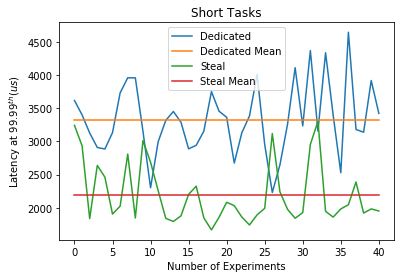

In [33]:
fig, ax = plt.subplots()

line1 = dedicated9999_1
line2 = offload9999_1
#line3 = round99

x1 = numpy.arange(len(line1))
x2 = numpy.arange(len(line2))
#x3 = numpy.arange(len(line3))


# x1new = numpy.linspace(x1.min(),x1.max(),20)
# x2new = numpy.linspace(x2.min(),x2.max(),20)

# line1_smooth = spline(x1, line1, x1new)
# line2_smooth = spline(x2, line2, x2new)

# storage_steal = numpy.array(storage_steal)
# storage_without_steal = numpy.array(storage_without_steal)

mean_line1 = [numpy.mean(line1)]*len(x1)
mean_line2 = [numpy.mean(line2)]*len(x2)
#mean_line3 = [numpy.mean(line3)]*len(x3)



#ax.plot(x1, default999, label='Round Robin')
ax.plot(x1, line1, label='Dedicated')
# ax.plot(x1new, line1_smooth, label='Dedicated Smooth')
ax.plot(x1, mean_line1, label='Dedicated Mean')



ax.plot(x2, line2, label='Steal')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
ax.plot(x2, mean_line2, label='Steal Mean')


#ax.plot(x3, line3, label='Round Robin')
# ax.plot(x2new, line2_smooth, label='Steal Smooth')
#ax.plot(x3, mean_line3, label='Round Robin Mean')


# ax.axvline(x2.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_xlabel('Number of Experiments')
ax.set_ylabel('Latency at $99.99^{th}(us)$')
# ax.set_ylim((820,880))
ax.legend()
ax.set_title(r'Short Tasks')
plt.savefig('plots/off_ded_nic_9999.png', bbox_inches='tight', dpi=300)
plt.show()

In [41]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

print("offload")
print(99.9, mean_confidence_interval(offload999))
print(99, mean_confidence_interval(offload99))
print(99.99,mean_confidence_interval(offload9999))
print("$$$$$$$$$$$$$")

print("dedicated")
print(99.9, mean_confidence_interval(dedicated999))
print(99, mean_confidence_interval(dedicated99))
print(99.99,mean_confidence_interval(dedicated9999))
print("$$$$$$$$$$$$$$$$")

print("round robin")
print(99.9, mean_confidence_interval(round999))
print(99, mean_confidence_interval(round99))
print(99.99,mean_confidence_interval(round9999))

offload
99.9 (1146.0387096774195, 1132.494989674436, 1159.582429680403)
99 (854.1354838709677, 850.1987971311427, 858.0721706107928)
99.99 (2110.074193548387, 1963.633563014156, 2256.5148240826184)
$$$$$$$$$$$$$
dedicated
99.9 (1320.835483870968, 1299.2805373191118, 1342.390430422824)
99 (859.4032258064517, 856.0789643586853, 862.7274872542181)
99.99 (3310.0, 3098.0804662326664, 3521.9195337673336)
$$$$$$$$$$$$$$$$
round robin
99.9 (1402.4645161290323, 1377.226411786386, 1427.7026204716785)
99 (887.8967741935483, 882.882916406988, 892.9106319801085)
99.99 (5400.14193548387, 4031.726856094404, 6768.557014873336)
